In [48]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram
from statsmodels.tsa.stattools import grangercausalitytests

Import big, beautiful dataset

In [3]:
master = pd.read_csv('/Users/satanhaha/Documents/MS ADS/Time Series/Final Project/time-series-gas-prices/data/master_df.csv')

Plot raw data

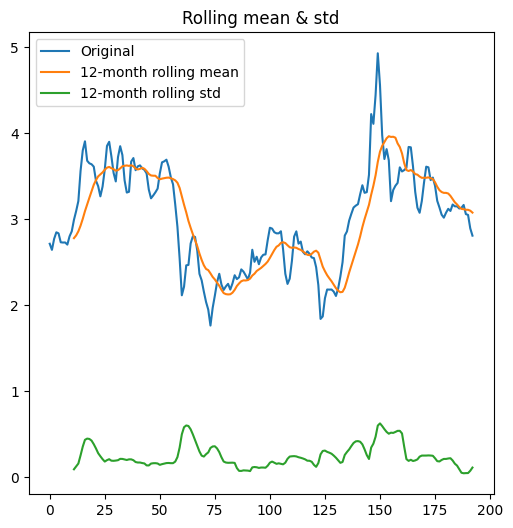

In [24]:
# plot rolling mean and std (12 month window)
rolling_mean = master['Monthly_Gas_Price'].rolling(window=12).mean()
rolling_std = master['Monthly_Gas_Price'].rolling(window=12).std()

plt.figure(figsize=(6, 6))
plt.plot(master['Monthly_Gas_Price'], label='Original')
plt.plot(rolling_mean, label='12-month rolling mean')
plt.plot(rolling_std, label='12-month rolling std')
plt.title('Rolling mean & std')
plt.legend()
plt.show()

Plot log to check for multiplicative seasonality
- looks the same so no multiplicative seasonality

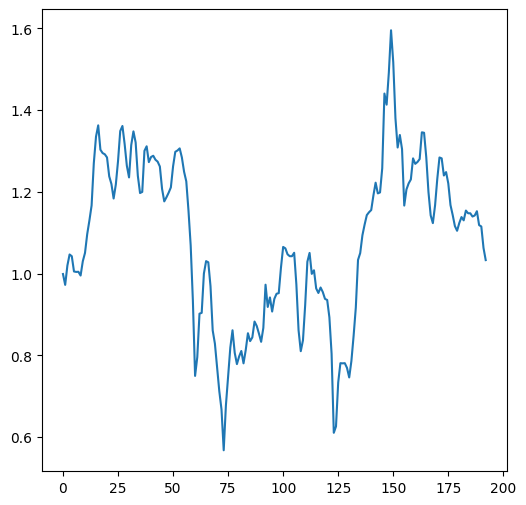

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(master['Monthly_Gas_Price'].index, np.log(master['Monthly_Gas_Price']))

ACF before differencing

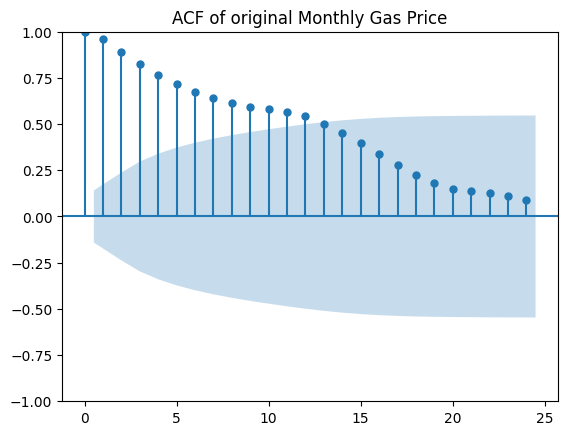

In [29]:
# autocorrelation; lag=24 since hourly
plot_acf(master['Monthly_Gas_Price'], lags=24)
plt.title("ACF of original Monthly Gas Price")
plt.show()

PACF before differencing

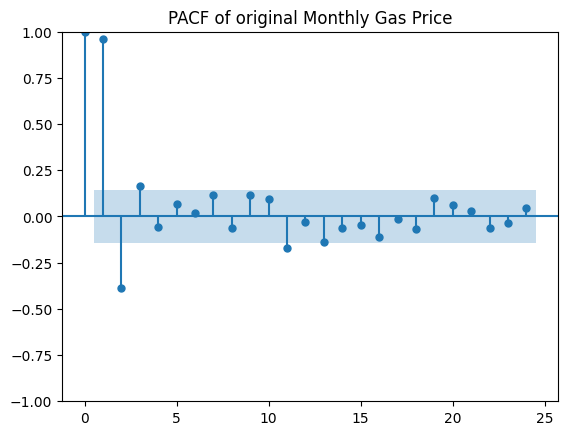

In [32]:
plot_pacf(master['Monthly_Gas_Price'], lags=24)
plt.title("PACF of original Monthly Gas Price")
plt.show()

Periodogram

/var/folders/6v/c7qppds910d2zl7x2w9hvdfm0000gn/T/ipykernel_31617/3143403766.py:12: RuntimeWarning: divide by zero encountered in divide
  period_hours = np.where(f > 0, 1 / f, np.nan)


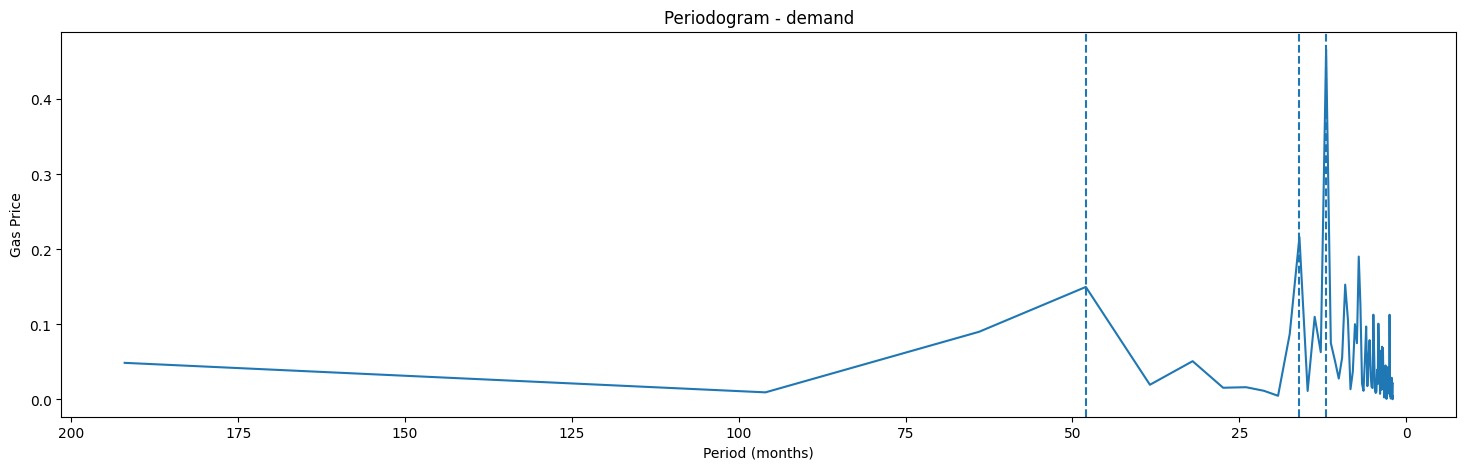

In [45]:
# y
y = master['Monthly_Gas_Price']

# remove mean
y_centered = y - y.mean()

y_diff = y.diff().dropna()
x = y_diff.values

f, Pxx = periodogram(x, fs=1, window="hann", scaling="density", detrend=False)

period_hours = np.where(f > 0, 1 / f, np.nan)

mask = (period_hours >= 2) & (period_hours <= 400)

plt.figure(figsize=(18,5))
plt.plot(period_hours[mask], Pxx[mask])
plt.gca().invert_xaxis()
plt.title("Periodogram - demand")
plt.xlabel("Period (months)")
plt.ylabel("Gas Price")
plt.axvline(12, linestyle="--")
plt.axvline(16, linestyle="--")
plt.axvline(48, linestyle="--")
plt.show()

Bar chart to see q2 spikes
- q2 and q3 are summer months

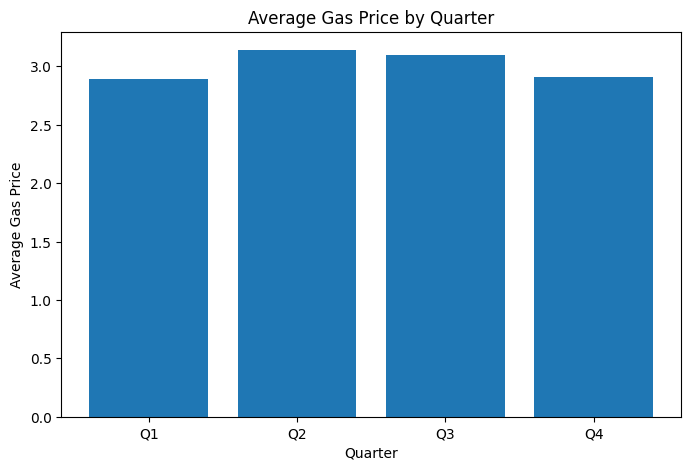

In [47]:
# make quarter column
master['Unnamed: 0'] = pd.to_datetime(master['Unnamed: 0'])
master['quarter'] = master['Unnamed: 0'].dt.quarter

# agg by mean
quarter_avg = (master.groupby('quarter')['Monthly_Gas_Price'].mean().reset_index())

# plot bar
plt.figure(figsize=(8,5))
plt.bar(quarter_avg['quarter'], quarter_avg['Monthly_Gas_Price'])
plt.xticks([1,2,3,4], ['Q1','Q2','Q3','Q4'])

plt.title("Average Gas Price by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Average Gas Price")

plt.show()

Granger Causality Test

In [49]:
gc_price_stock = master[['Monthly_Gas_Price', 'Gasoline_Stock']].dropna().copy()

# granger assumes stationarity
gc_price_stock_diff = gc_price_stock.diff().dropna()

max_lag = 12

results = grangercausalitytests(
    gc_price_stock_diff[['Monthly_Gas_Price', 'Gasoline_Stock']],
    maxlag=max_lag,
    verbose=True
)

results


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1583  , p=0.0243  , df_denom=188, df_num=1
ssr based chi2 test:   chi2=5.2406  , p=0.0221  , df=1
likelihood ratio test: chi2=5.1700  , p=0.0230  , df=1
parameter F test:         F=5.1583  , p=0.0243  , df_denom=188, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.3173  , p=0.0009  , df_denom=185, df_num=2
ssr based chi2 test:   chi2=15.0302 , p=0.0005  , df=2
likelihood ratio test: chi2=14.4653 , p=0.0007  , df=2
parameter F test:         F=7.3173  , p=0.0009  , df_denom=185, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.3796  , p=0.0004  , df_denom=182, df_num=3
ssr based chi2 test:   chi2=19.8749 , p=0.0002  , df=3
likelihood ratio test: chi2=18.8979 , p=0.0003  , df=3
parameter F test:         F=6.3796  , p=0.0004  , df_denom=182, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7429  , p=0.0012  

/opt/anaconda3/envs/titanic-xgb/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(5.158326647673431),
    np.float64(0.02426847492976138),
    np.float64(188.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(5.240640370774603),
    np.float64(0.022065150501069764),
    np.int64(1)),
   'lrtest': (np.float64(5.170032904167215),
    np.float64(0.022979780646708442),
    np.int64(1)),
   'params_ftest': (np.float64(5.158326647673346),
    np.float64(0.024268474929762626),
    np.float64(188.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(7.317333962775272),
    np.float64(0.0008740945638793782),
    np.float64(185.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(15.030199491105963),
    np.float64(0.0005447956729845828),
    np.int64(2)),
   'lrtest': (np.float64(14.465310036601295),
    np.float64(0.0007225997983585603),
    np.int64(2)),
   'params_ftest': (np.float64(7.317333962708723),
    np.float64(0.0008740945639332845),
    np.float64(185.0),
    2.0)},
   array([[0., 0., 1., 0.